# Example: University

In [1]:
import datajoint as dj
schema = dj.Schema('university')

[2024-09-09 19:24:45,756][INFO]: Connecting root@localhost:3306
[2024-09-09 19:24:45,776][INFO]: Connected root@localhost:3306


In [2]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned   # university-wide ID number
    ---
    first_name      : varchar(40)
    last_name       : varchar(40)
    sex             : enum('F', 'M', 'U')
    date_of_birth   : date
    home_address    : varchar(120) # mailing street address
    home_city       : varchar(60)  # mailing address
    home_state      : char(2)      # US state acronym: e.g. OH
    home_zip        : char(10)     # zipcode e.g. 93979-4979
    home_phone      : varchar(20)  # e.g. 414.657.6883x0881
    """

In [3]:
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # abbreviated department name, e.g. BIOL
    ---
    dept_name    : varchar(200)  # full department name
    dept_address : varchar(200)  # mailing address
    dept_phone   : varchar(20)
    """

In [4]:
@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> Department
    declare_date :  date  # when student declared her major
    """

In [5]:
@schema
class Course(dj.Manual):
    definition = """
    -> Department
    course  : int unsigned   # course number, e.g. 1010
    ---
    course_name :  varchar(200)  # e.g. "Neurobiology of Sensation and Movement."
    credits     :  decimal(3,1)  # number of credits earned by completing the course
    """
    
@schema
class Term(dj.Manual):
    definition = """
    term_year : year
    term      : enum('Spring', 'Summer', 'Fall')
    """

@schema
class Section(dj.Manual):
    definition = """
    -> Course
    -> Term
    section : char(1)
    ---
    auditorium   :  varchar(12)
    """
    
@schema
class CurrentTerm(dj.Manual):
    definition = """
    -> Term
    """

@schema
class Enroll(dj.Manual):
    definition = """
    -> Student
    -> Section
    """

@schema
class LetterGrade(dj.Lookup):
    definition = """
    grade : char(2)
    ---
    points : decimal(3,2)
    """
    contents = [
        ['A',  4.00],
        ['A-', 3.67],
        ['B+', 3.33],
        ['B',  3.00],
        ['B-', 2.67],
        ['C+', 2.33],
        ['C',  2.00],
        ['C-', 1.67],
        ['D+', 1.33],
        ['D',  1.00],
        ['F',  0.00]
        ]

@schema
class Grade(dj.Manual):
    definition = """
    -> Enroll
    ---
    -> LetterGrade
    """


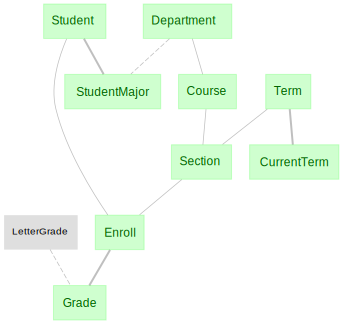

In [6]:
dj.Diagram(schema)

# Populate
Use `faker` to populate the database.

In [7]:
from tqdm import tqdm
import faker
import random
import datetime
fake = faker.Faker()

In [8]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [9]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(100,300), yield_students()))

In [10]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Maria,Quinn,F,2007-10-30,41832 Freeman Stream,Amyfurt,DE,84452,951.760.2919x454
101,Crystal,Miller,F,2004-01-16,591 John Terrace,East Jorge,MO,93808,342-853-1749x85964
102,Francisco,Vasquez,M,2009-03-02,7562 Harrison Trail,Debrafort,VA,21179,(681)217-9339x204
103,Dr.,Jacqueline,F,2009-06-17,47830 Jackson Gardens,Bellfurt,ND,85817,845-290-5200
104,Lee,Davis,M,1991-07-06,34042 Romero Green,South Aliciaville,OH,15578,001-921-865-7421x303
105,Courtney,Meyer,F,1992-09-25,63843 Smith Mission Suite 258,Lake Robertfort,PA,82567,435.246.7265
106,Gloria,Lyons,F,2005-11-23,638 Ramirez River Suite 608,Castilloport,TX,29198,001-728-820-0821x058
107,John,Cantu,M,1994-10-17,63086 Hawkins Well Suite 056,East Mikefort,MI,66116,(466)507-5309x931
108,Leslie,Lee,F,1996-11-02,467 Fletcher Cape Apt. 398,Lake Emma,GA,87235,400.779.5116
109,Angela,Johnson,F,2004-04-08,93422 Michael Vista Apt. 260,Lake Frank,CO,62659,+1-493-714-3781


In [11]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [12]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [13]:
StudentMajor()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL",declare_date when student declared her major
100,MATH,2023-03-22
101,BIOL,1999-08-13
102,PHYS,2024-09-02
103,CS,2003-03-03
104,PHYS,2017-09-13
105,MATH,2015-09-03
107,BIOL,2019-07-06
110,CS,2012-03-30
111,CS,2023-01-15
112,CS,2019-12-05


In [14]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

In [15]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2019) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [16]:
# Enrollment 
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

100%|██████████| 200/200 [00:06<00:00, 30.48it/s]


In [17]:
# assign random grades
grades = LetterGrade.fetch('grade')

grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

In [18]:
Grade()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,grade
100,CS,4970,2001,Summer,a,A
101,PHYS,3210,2012,Summer,b,A
102,CS,2100,2000,Fall,b,A
102,MATH,1210,2001,Summer,d,A
103,BIOL,1030,2015,Summer,c,A
103,MATH,1260,2018,Spring,b,A
103,PHYS,3210,2016,Summer,a,A
105,BIOL,2330,2015,Summer,c,A
105,CS,2100,2018,Spring,a,A
106,BIOL,2210,2001,Summer,b,A
